# Tarea 2 Panel y Pseudo-experimentos - Pauta

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
import linearmodels.panel as lmp
import pytwoway as tw
import bipartitepandas as bpd
import seaborn as sns
from linearmodels.iv import IV2SLS

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import os
os.chdir('../data')
print(os.getcwd())

c:\Users\juanc\OneDrive\Documentos\LAB-MAA\data


### Preguntas:

### 1. Crear un set de datos de frecuencia mensual que permita estudiar el efecto de las cuarentenas dinamicas (paso a paso) sobre la calidad del aire en las comunas que poseen estaciones de medicion durante 2021. Queda a discrecion como agregar y generar el set de datos final para estimacion.

In [29]:
#set datos paso a paso
df = pd.read_csv("paso_a_paso.csv");
aux = df[[col for col in df.columns if '2021' in col]];
aux.columns = pd.to_datetime(aux.columns);
df_mensual = aux.transpose().resample('M').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]).transpose();
df_mensual.columns = [f"{col.month:02d}" for col in df_mensual.columns];
df21 = pd.concat([df[['codigo_region', 'region_residencia', 'codigo_comuna', 'comuna_residencia', 'zona']], df_mensual], axis=1);
df21_melted = df21.melt(id_vars=['codigo_region', 'region_residencia', 'codigo_comuna', 'comuna_residencia', 'zona'], 
                        var_name='Mes', value_name='Paso');
df21_melted['Mes'] = df21_melted['Mes'].astype(str);

#set datos MP2.5
mp = pd.read_csv("MP2.5-2021_std.csv");
mp.drop(columns=["Rancagua_II", "Valdivia_II", "Coyhaique_II", "Talca_La_Florida", "Alerce"], inplace=True);
nombres = {mp.columns[i]: new_name for i, new_name in enumerate([
    'Hora', 'Arica', 'Alto Hospicio', 'Antofagasta', 'Copiapó', 'Huasco', 'Coquimbo', 'La Serena', 'Concón', 'Valparaíso',
    'Viña del Mar', 'Independencia', 'La Florida', 'Las Condes', 'Santiago', 'Pudahuel', 'El Bosque', 'Cerro Navia',
    'Puente Alto', 'Quilicura', 'Rancagua', 'Rengo', 'San Fernando', 'Curicó', 'Maule', 'Talca', 'Linares', 'Nielol',
    'Las Encinas', 'Padre Las Casas', 'Valdivia', 'Osorno', 'Mirasol', 'Coyhaique', 'Punta Arenas', 'La Unión', 'Vialidad', 'Talagante'])}
mp.rename(columns=nombres, inplace=True);
mp['Hora'] = pd.to_datetime(mp['Hora']);
mp['Fecha'] = mp['Hora'].dt.date;
aux = mp.groupby('Fecha').mean();
aux2 = aux.T;
aux2.columns = pd.to_datetime(aux2.columns);
aux2 = aux2.apply(pd.to_numeric, errors='coerce')
mp = aux2.groupby(aux2.columns.to_period('M'), axis=1).mean();
mp = mp.drop(mp.index[0]);
mp = mp.dropna();
mp.reset_index(inplace=True);
mp.rename(columns={'index': 'Comuna'}, inplace=True);
mp_melted = mp.melt(id_vars=['Comuna'], var_name='Mes', value_name='MP');
mp_melted['Mes'] = mp_melted['Mes'].astype(str).str.slice(5, 7);

mp_melted['Comuna'] = mp_melted['Comuna'].astype(str);
df21_melted.rename(columns={'comuna_residencia': 'Comuna'}, inplace=True);

com = set(df21_melted['Comuna']).intersection(set(mp_melted['Comuna']));
mes = set(df21_melted['Mes']).intersection(set(mp_melted['Mes']));

df21_aux = df21_melted[df21_melted['Comuna'].isin(com) & df21_melted['Mes'].isin(mes)];
mp_aux = mp_melted[mp_melted['Comuna'].isin(com) & mp_melted['Mes'].isin(mes)];

#dataset completo (merge en esta fase de MP y paso a paso)
df = pd.merge(df21_aux, mp_aux, on=['Comuna', 'Mes'], suffixes=('_df21', '_mp'));

#nacimientos
nac21 = pd.read_csv("2021-Nacimientos.csv");
date_cols = [col for col in nac21.columns if col.startswith('2021')]
nac21_2021 = nac21[date_cols]
nac21_2021 = nac21_2021.apply(pd.to_numeric, errors='coerce')
dates = pd.to_datetime(date_cols, format='%Y-%m-%d')
monthly_data = nac21_2021.groupby(dates.month, axis=1).mean()
monthly_data.columns = monthly_data.columns.astype(str)
non_date_cols = nac21[['Region', 'Codigo region', 'Comuna', 'Codigo comuna']]
nac21 = pd.concat([non_date_cols, monthly_data], axis=1)
nac21_melted = nac21.melt(id_vars=['Region', 'Codigo region', 'Comuna', 'Codigo comuna'], var_name='Mes', value_name='Nacimientos')
nac21_melted.rename(columns={'Comuna': 'Comuna'}, inplace=True)
nac21_melted['Mes'] = nac21_melted['Mes'].astype(int)
df["Mes"] = df["Mes"].astype(int);
df['Comuna'] = df['Comuna'].astype(str);
nac21_melted['Comuna'] = nac21_melted['Comuna'].astype(str);

#al archivo principal se agrega nacimientos
df = pd.merge(df, nac21_melted[['Comuna', 'Mes', 'Nacimientos', 'Codigo comuna']], on=['Comuna', 'Mes'], suffixes=('_df21', '_nac21'));

#defunciones
def21 = pd.read_csv("2021-Defunciones.csv");
date_cols = [col for col in def21.columns if col.startswith('2021')]
def21_2021 = def21[date_cols]
def21_2021 = def21_2021.apply(pd.to_numeric, errors='coerce')
dates = pd.to_datetime(date_cols, format='%Y-%m-%d')
monthly_data = def21_2021.groupby(dates.month, axis=1).mean()
monthly_data.columns = monthly_data.columns.astype(str)
non_date_cols = def21[['Region', 'Codigo region', 'Comuna', 'Codigo comuna']]
def21 = pd.concat([non_date_cols, monthly_data], axis=1)
def21_melted = def21.melt(id_vars=['Region', 'Codigo region', 'Comuna', 'Codigo comuna'], var_name='Mes', value_name='Defunciones')
def21_melted.rename(columns={'Comuna': 'Comuna'}, inplace=True)
def21_melted['Mes'] = def21_melted['Mes'].astype(int)
df["Mes"] = df["Mes"].astype(int);
df['Comuna'] = df['Comuna'].astype(str);
def21_melted['Comuna'] = def21_melted['Comuna'].astype(str);

#al archivo principal se agrega defunciones
df = pd.merge(df, def21_melted[['Comuna', 'Mes', 'Defunciones', 'Codigo comuna']], on=['Comuna', 'Mes'], suffixes=('_df21', '_def21'));

#movilidad
week = pd.read_csv("ISCI_weeks.csv");
week['fecha_termino'] = pd.to_datetime(week['fecha_termino']);
week_2021 = week[week['fecha_termino'].dt.year == 2021];
week_2021['Mes'] = week_2021['fecha_termino'].dt.month;
weekly_avg = week_2021.groupby(['nom_comuna', 'comuna', 'Mes'])['var_salidas'].mean().reset_index();
week = weekly_avg[['nom_comuna', 'comuna', 'Mes', 'var_salidas']];
week.rename(columns={'var_salidas': 'SalidasSemana'}, inplace=True);

week['Mes'] = week['Mes'].astype(int);
week['comuna'] = week['comuna'].astype(int);

#merge con movilidad
df = pd.merge(df, week[['comuna', 'Mes', 'SalidasSemana']], left_on=['codigo_comuna', 'Mes'], right_on=['comuna', 'Mes'], how='left');
#df.drop(columns=['comuna'], inplace=True);
df = df.drop(columns=['Codigo comuna_df21', 'Codigo comuna_def21', 'comuna']);

#contactos estrechos
cont = pd.read_csv("ContactosPorComuna.csv");
date_cols = [col for col in cont.columns if '-' in col];
cont_melted = cont.melt(id_vars=['Region', 'Codigo region', 'Comuna', 'Codigo comuna', 'Poblacion'], 
                        value_vars=date_cols, var_name='fecha_termino', value_name='var_salidas');
cont_melted['fecha_termino'] = pd.to_datetime(cont_melted['fecha_termino'], errors='coerce');
cont_melted = cont_melted.dropna(subset=['fecha_termino']);
cont_melted['var_salidas'] = pd.to_numeric(cont_melted['var_salidas'], errors='coerce');
cont_melted = cont_melted.dropna(subset=['var_salidas']);
cont_melted['Mes'] = cont_melted['fecha_termino'].dt.month;
monthly_avg = cont_melted.groupby(['Region', 'Codigo region', 'Comuna', 'Codigo comuna', 'Mes'])['var_salidas'].mean().reset_index();

cont = monthly_avg[['Codigo comuna', 'Mes', 'var_salidas']];
cont.rename(columns={'var_salidas': 'ContactosEstrechos'}, inplace=True);
cont['Mes'] = cont['Mes'].astype(int);
cont["Codigo comuna"] = cont["Codigo comuna"].astype(int);

#merge con contactos estrechos
df = pd.merge(df, cont, left_on=['codigo_comuna', 'Mes'], right_on=['Codigo comuna', 'Mes'], how='left');

#discretizacion de las variables
df["Verano"] = df["Mes"].apply(lambda x: 1 if x in [1, 2, 3] else 0);
df["Otoño"] = df["Mes"].apply(lambda x: 1 if x in [4, 5, 6] else 0);
df["Invierno"] = df["Mes"].apply(lambda x: 1 if x in [7, 8, 9] else 0);
df["Primavera"] = df["Mes"].apply(lambda x: 1 if x in [10, 11, 12] else 0);

df["Etapa1_2"] = df["Paso"].apply(lambda x: 1 if x <= 2  else 0);
df["Etapa3_4"] = df["Paso"].apply(lambda x: 1 if x >= 3 else 0);

#definir los indices y otras variables relevantes
df.set_index(['Comuna', 'Mes'], inplace=True);
df.sort_index(level=['Comuna', 'Mes'], inplace=True);
df = df[df['zona'] != 'Rural'];
df['RM']=df["codigo_region"].apply(lambda x: 1 if x == 13 else 0);
df['Sur']=df["codigo_region"].apply(lambda x: 1 if (x >=6 and x!=13 and x!=15) else 0);
 
df.drop(columns=['zona', 'region_residencia', 'Codigo comuna'], inplace=True);
df.describe()

,codigo_region,codigo_comuna,Paso,MP,Nacimientos,Defunciones,SalidasSemana,ContactosEstrechos,Verano,Otoño,Invierno,Primavera,Etapa1_2,Etapa3_4,RM,Sur
count,348.000000,348.000000,348.00000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,9.068966,9219.103448,2.58046,20.546536,9.166628,4.658705,0.875098,2.247289,0.250000,0.250000,0.250000,0.250000,0.497126,0.502874,0.310345,0.413793
std,4.099042,4086.521871,1.14729,17.089705,9.498249,3.631811,0.062575,1.251456,0.433636,0.433636,0.433636,0.433636,0.500712,0.500712,0.463301,0.493221
min,2.000000,2101.000000,1.00000,3.100000,0.000000,0.064516,0.557162,0.635289,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,6101.000000,2.00000,9.569457,0.428214,1.642204,0.836397,1.330236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,9112.000000,3.00000,13.882500,6.961538,4.327381,0.885747,1.791371,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,13.000000,13110.000000,4.00000,25.363554,14.223214,6.686348,0.921590,2.925805,0.250000,0.250000,0.250000,0.250000,1.000000,1.000000,1.000000,1.000000
max,15.000000,15101.000000,5.00000,102.235875,50.375000,17.866667,1.002001,8.338972,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2. Ejecute un modelo Pooled OLS para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado.

In [30]:
y = df['MP'];
X = df[['SalidasSemana', 'Defunciones', 'Etapa1_2', 'Invierno', 'Otoño','RM','Sur']];
X = sm.add_constant(X);
model = lmp.PanelOLS(y, X);
mco = model.fit();
print(mco)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     MP   R-squared:                        0.4888
Estimator:                   PanelOLS   R-squared (Between):              0.5229
No. Observations:                 348   R-squared (Within):               0.4792
Date:                Thu, May 30 2024   R-squared (Overall):              0.4888
Time:                        10:58:09   Log-likelihood                   -1364.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      46.449
Entities:                          29   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(7,340)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             46.449
                            

### 3. Ejecute un modelo efectos fijos para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado.

In [12]:
y = df['MP'];
X = df[['SalidasSemana', 'Defunciones', 'Etapa1_2', 'Invierno', 'Otoño']];
X = sm.add_constant(X);
model = lmp.PanelOLS(y,X, entity_effects=True);
fe = model.fit(cov_type="robust");
print(fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     MP   R-squared:                        0.4912
Estimator:                   PanelOLS   R-squared (Between):             -1.2387
No. Observations:                 348   R-squared (Within):               0.4912
Date:                Thu, May 30 2024   R-squared (Overall):              0.1099
Time:                        10:44:41   Log-likelihood                   -1320.2
Cov. Estimator:                Robust                                           
                                        F-statistic:                      60.623
Entities:                          29   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(5,314)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             63.125
                            

### 4. Ejecute un modelo de efectos aleatorios para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. 

In [13]:
y = df['MP'];
X = df[['ContactosEstrechos', 'Defunciones', 'Etapa1_2', 'Invierno', 'Otoño']];
X = sm.add_constant(X);
model = lmp.RandomEffects(y,X);
re = model.fit(cov_type="robust")
print(re)

                        RandomEffects Estimation Summary                        
Dep. Variable:                     MP   R-squared:                        0.4312
Estimator:              RandomEffects   R-squared (Between):              0.0236
No. Observations:                 348   R-squared (Within):               0.4567
Date:                Thu, May 30 2024   R-squared (Overall):              0.3613
Time:                        10:44:42   Log-likelihood                   -1350.1
Cov. Estimator:                Robust                                           
                                        F-statistic:                      51.852
Entities:                          29   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(5,342)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             53.079
                            

### 5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

In [14]:
import numpy.linalg as la
from scipy import stats
def hausman(fe, re):
    diff = fe.params-re.params
    psi = fe.cov - re.cov
    dof = diff.size -1
    W = diff.dot(la.inv(psi)).dot(diff)
    pval = stats.chi2.sf(W, dof)
    return W, dof, pval
htest = hausman(fe, re)
print("Hausman Test: chi-2 = {0}, df = {1}, p-value = {2}".format(htest[0], htest[1], htest[2]))

Hausman Test: chi-2 = nan, df = 6, p-value = nan


In [15]:
print(lmp.compare({"FE": fe, "RE": re, "Pooled": mco}))

                           Model Comparison                           
                                   FE                RE         Pooled
----------------------------------------------------------------------
Dep. Variable                      MP                MP             MP
Estimator                    PanelOLS     RandomEffects       PanelOLS
No. Observations                  348               348            348
Cov. Est.                      Robust            Robust     Unadjusted
R-squared                      0.4912            0.4312         0.3965
R-Squared (Within)             0.4912            0.4567         0.4727
R-Squared (Between)           -1.2387            0.0236         0.1269
R-Squared (Overall)            0.1099            0.3613         0.3965
F-statistic                    60.623            51.852         37.334
P-value (F-stat)               0.0000            0.0000         0.0000
=====================     ===========   ===============   ============
const 

### 6. Ejecute un modelo de efectos aleatorios correlacionados (CRE) para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. Es este modelo adecuado, dada la data disponible, para modelar el componente no observado?

En el análisis se debe incluir la significancia de las variables, los coeficientes y una explicación hacia la variable dependiente. En adición, se debe explicar la incorporación de variables para explicar heterogeneidad no observada.

In [16]:
X = df.drop(['MP'], axis=1);
Xm = X.groupby(by='Comuna').transform('mean');
Xm.columns = ['m{}'.format(column) for column in Xm.columns];
Xc = pd.merge(df, Xm, left_index=True, right_index=True);
Xc = Xc.apply(pd.to_numeric, errors='coerce')
Y = Xc['MP'];
#independent_vars = ['Paso', 'mPaso', 'Invierno', 'Otoño', 'Verano'];
independent_vars = ['ContactosEstrechos', 'Defunciones', 'Etapa1_2', 'Invierno', 'Otoño', 'mContactosEstrechos', 'mDefunciones'];
X = Xc[independent_vars];
X = sm.add_constant(X);

model=lmp.RandomEffects(y,X)
cre=model.fit(cov_type="robust")
print(cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                     MP   R-squared:                        0.4548
Estimator:              RandomEffects   R-squared (Between):              0.3021
No. Observations:                 348   R-squared (Within):               0.4636
Date:                Thu, May 30 2024   R-squared (Overall):              0.4280
Time:                        10:44:42   Log-likelihood                   -1341.9
Cov. Estimator:                Robust                                           
                                        F-statistic:                      40.515
Entities:                          29   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(7,340)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             42.674
                            

### 7. Usando el modelo CRE, prediga la distribucion del componente no observado. Que puede inferir respecto de la heterogeneidad fija en el tiempo y su impacto en la calidad del aire?

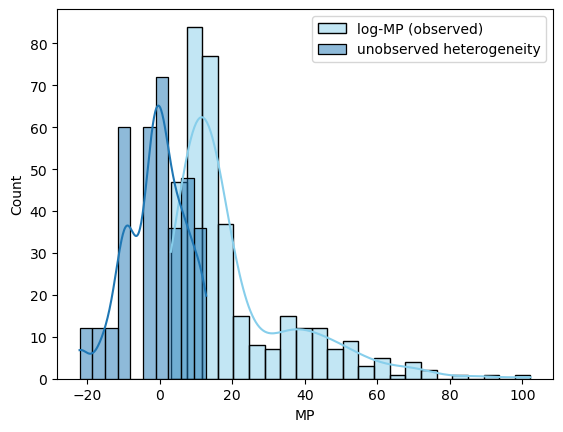

In [17]:
Xpred = X
#Xpred['Paso']=0
#Xpred['mPaso']=0
Xpred['Etapa1_2']=0
Xpred['Invierno']=0
Xpred['Otoño']=0
Xpred['ContactosEstrechos']=0
Xpred['Defunciones']=0
yhat = cre.predict(Xpred)

sns.histplot(data=y, color="skyblue", label="log-MP (observed)", kde=True)
sns.histplot(data=yhat, color="red", label="unobserved heterogeneity", kde=True)

plt.legend() 
plt.show()

### 8. Usando sus respuestas anteriores, que modelo prefiere? que se puede inferir en general respecto del efecto de las variables explicativas sobre el numero de trabajadores?

En vista de las comparaciones anteriores, tendría sentido escoger el modelo CRE pro sobre los otros.

In [18]:
print(lmp.compare({"FE": fe, "RE": re, "CRE": cre}))

                             Model Comparison                            
                                   FE                RE               CRE
-------------------------------------------------------------------------
Dep. Variable                      MP                MP                MP
Estimator                    PanelOLS     RandomEffects     RandomEffects
No. Observations                  348               348               348
Cov. Est.                      Robust            Robust            Robust
R-squared                      0.4912            0.4312            0.4548
R-Squared (Within)             0.4912            0.4567            0.4636
R-Squared (Between)           -1.2387            0.0236            0.3021
R-Squared (Overall)            0.1099            0.3613            0.4280
F-statistic                    60.623            51.852            40.515
P-value (F-stat)               0.0000            0.0000            0.0000
=====================     =========== 

### 9. Es posible que sus resultados anteriores tengan sesgo dado que las cuarentenas (paso a paso) son endogenas al comportamiento de las personas. Construya AL MENOS DOS instrumentos posibles para las cuarentenas dinamicas, de forma que se pueda corregir el sesgo y entender el efecto causal de las cuarentenas en el aire. Realice su estimacion considerando un modelo agrupado (ignorando el tiempo), y el modelo de panel.

In [19]:
def calcular_promedios_mensuales(carpeta):
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.csv')];
    datos = [];

    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo);
        df_temp = pd.read_csv(ruta);
        try:
            df_temp['fecha'] = pd.to_datetime(archivo.split('-')[0] + '-' + archivo.split('-')[1] + '-2021', format='%d-%m-%Y');
        except ValueError:
            df_temp['fecha'] = pd.to_datetime('2021-' + archivo.split('-')[1] + '-' + archivo.split('-')[2].split('.')[0], format='%Y-%m-%d');
        df_temp = df_temp[['Codigo comuna', 'Poblacion', 'Casos Confirmados', 'fecha']];
        df_temp['Mes'] = df_temp['fecha'].dt.month;
        datos.append(df_temp);
    df_concatenado = pd.concat(datos);
    df_mensual = df_concatenado.groupby(['Codigo comuna', 'Mes']).agg({
        'Casos Confirmados': 'sum',
        'Poblacion': 'first'
    }).reset_index();

    df_mensual['CasosConfirmados'] = df_mensual['Casos Confirmados'] / df_mensual['Poblacion'];

    return df_mensual;

carpeta = 'Producto 2';
promedios_mensuales = calcular_promedios_mensuales(carpeta);
df['codigo_comuna'] = df['codigo_comuna'].astype(int);

df = df.reset_index();
df = pd.merge(df, promedios_mensuales, left_on=['codigo_comuna', 'Mes'], right_on=['Codigo comuna', 'Mes'], how='left');
df = df.drop(columns=['Codigo comuna']);

df['CasosRezagados'] = df.groupby('Comuna')['CasosConfirmados'].shift(1);
df.set_index(['Comuna', 'Mes'], inplace=True);
df.sort_index(level=['Comuna', 'Mes'], inplace=True);
dfiv = df

df.head(15)

codigo_region  codigo_comuna  Paso         MP  Nacimientos  \
Comuna      Mes                                                               
Antofagasta 1                2           2101     1   5.875397    15.520000   
            2                2           2101     1   6.840503    14.160000   
            3                2           2101     2   7.370589    16.230769   
            4                2           2101     1   9.726389    15.269231   
            5                2           2101     2  14.531036    15.826087   
            6                2           2101     3  13.708152    15.708333   
            7                2           2101     3  17.025000    14.037037   
            8                2           2101     4  13.604839    15.720000   
            9                2           2101     4  10.397361    15.833333   
            10               2           2101     4  11.670699    14.392857   
            11               2           2101     4   9.452083    17.080000   
            12               2           2101     4   6.995104    13.137931   
Arica       1               15          15101     2  10.193726     8.880000   
            2               15          15101     1  12.417336     8.360000   
            3               15          15101     2  13.250628     9.576923   

                 Defunciones  SalidasSemana  ContactosEstrechos  Verano  \
Comuna      Mes                                                           
Antofagasta 1       8.000000       0.823707            2.553807       1   
            2       7.607143       0.808953            1.416257       1   
            3       7.451613       0.870020            1.372256       1   
            4       6.833333       0.817688            1.306003       0   
            5       6.709677       0.897977            1.643399       0   
            6       7.433333       0.887465            1.737572       0   
            7       7.967742       0.901401            1.961842       0   
            8       7.451613       0.912579            1.998472       0   
            9       6.266667       0.910950            2.634658       0   
            10      5.516129       0.909338            4.152201       0   
            11      5.900000       0.910293            4.033026       0   
            12      7.096774       0.936629            4.133493       0   
Arica       1       4.645161       0.922646            3.248714       1   
            2       5.678571       0.855577            1.822036       1   
            3       5.935484       0.941723            1.555125       1   

                 Otoño  Invierno  Primavera  Etapa1_2  Etapa3_4  RM  \
Comuna      Mes                                                       
Antofagasta 1        0         0          0         1         0   0   
            2        0         0          0         1         0   0   
            3        0         0          0         1         0   0   
            4        1         0          0         1         0   0   
            5        1         0          0         1         0   0   
            6        1         0          0         0         1   0   
            7        0         1          0         0         1   0   
            8        0         1          0         0         1   0   
            9        0         1          0         0         1   0   
            10       0         0          1         0         1   0   
            11       0         0          1         0         1   0   
            12       0         0          1         0         1   0   
Arica       1        0         0          0         1         0   0   
            2        0         0          0         1         0   0   
            3        0         0          0         1         0   0   

                 Casos Confirmados  Poblacion  CasosConfirmados  \
Comuna      Mes                                                   
Antofagasta 1             301042.0   425725.0          

In [20]:
df = df.dropna(subset=['CasosRezagados']);
df["MP"] = df["MP"].astype(float);
iv_model = IV2SLS(df['MP'], sm.add_constant(df[['ContactosEstrechos', 'Defunciones', 'Invierno', 'Otoño']]), 
                           df[['Etapa1_2']], df[['CasosRezagados']]);
iv_results = iv_model.fit(cov_type='unadjusted')
print("Modelo Agrupado")
print(iv_results.summary)

Modelo Agrupado
                          IV-2SLS Estimation Summary                          
Dep. Variable:                     MP   R-squared:                      0.1574
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1440
No. Observations:                 319   F-statistic:                    139.58
Date:                Thu, May 30 2024   P-value (F-stat)                0.0000
Time:                        10:44:43   Distribution:                  chi2(5)
Cov. Estimator:            unadjusted                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
const                  38.150     7.9391     4.8053     0.0000      22.590      53.711
Cont

In [21]:
from fixedeffect.iv import iv2sls, ivgmm, ivtest
dfiv = dfiv.reset_index()
formula = 'MP ~ Defunciones + Invierno + Otoño + SalidasSemana|Comuna+Mes|0|(Etapa1_2~CasosRezagados+ContactosEstrechos)'
model_iv2sls = iv2sls(data_df = dfiv,
                      formula = formula)
result = model_iv2sls.fit()
print(result.params)
print(result.bse)

dependent variable(s): ['MP']
independent(exogenous): ['Defunciones', 'Invierno', 'Otoño', 'SalidasSemana']
category variables(fixed effects): ['Comuna', 'Mes']
cluster variables: ['0']
endogenous variables: ['Etapa1_2']
instruments: ['CasosRezagados', 'ContactosEstrechos']
const            34.792458
Defunciones      -0.248270
Invierno          8.698115
Otoño             8.698115
SalidasSemana    -4.221648
hat_Etapa1_2    -27.646905
dtype: float64
const            19.288770
Defunciones       0.904449
Invierno          4.822193
Otoño             4.822193
SalidasSemana    22.512614
hat_Etapa1_2      7.554315
dtype: float64
